In [84]:
import os
import re
from collections import defaultdict
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from bs4 import BeautifulSoup
import gc
import seaborn as sns
import json

## Read the character's content files

In [26]:
def read_txt_files(folder_path):
    """Reads all .txt files in a given folder and stores their contents in a dictionary.

    Args:
        folder_path: The path to the folder containing the .txt files.

    Returns:
        A dictionary where the keys are the filenames (without the .txt extension) and the values are the file contents.
    """

    file_contents = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            filepath = os.path.join(folder_path, filename)
            with open(filepath,'r') as f:
                file_contents[filename[:-4]] = f.read() # [:-4] to remove the .txt extension
    return file_contents

### We use the html content for creating the relationships between the characters (links)

In [27]:
html_folder_path = r"./onepiece_html"
html_content_dict = read_txt_files(html_folder_path)

In [28]:
# Print the first key and value in the dictionary
key = list(html_content_dict.keys())[0]
value = html_content_dict[key]
print(f"Key: {key}")
print(f"Value: {value}")

Key: A O
Value: <!DOCTYPE html>
<html class="client-nojs sse-other" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>A O | One Piece Wiki | Fandom</title>
<script>document.documentElement.className="client-js sse-other";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"5bb2d71cef47a005eab30f8314307a8f","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"A_O","wgTitle":"A O","wgCurRevisionId":2024738,"wgRevisionId":2024738,"wgArticleId":45158,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Humans","Male Characters","Pirate Captains","Whitebeard Pirates' Subordinates","Swordsmen"],"wgPageContentLanguage":"en","wgPageContentModel":"wi

### We use the cleaned files for creating the node attribute `word_count`

In [29]:
clear_content_folder_path = r"./onepiece_cleaned"
clear_content_dict = read_txt_files(clear_content_folder_path)

In [30]:
# Print the first key and value in the dictionary
key = list(clear_content_dict.keys())[0]
value = clear_content_dict[key]
print(f"Key: {key}")
print(f"Value: {value}")

Key: A O
Value: A O
is an infamous
New World
pirate
and
captain
of the
A O Pirates
.
He and his crew were subordinates to
Whitebeard
.
Appearance
[
]
A O is a very tall man with a long, square shaped face, hollow eyes under prominent eyebrows, dark sideburns that go all the way down to his chin, and greenish long wavy hair. On his head, he wears a yellow and brown striped bandanna and over it is a tricorn captain's hat with what appears to be his
Jolly Roger
on it, a white skull wearing an animal-like hood. He also wears a dark blue, open shirt with the sleeves rolled up and a ruffled collar, and elaborate earrings made up by three little jewels each on both ears.
Personality
[
]
Not much is known about A O's personality other than that he is very loyal to
Whitebeard
since he was willing to risk his own life to save
Ace
from execution instead of fleeing through the path he had cleared with his
power
.
He was overjoyed when
Luffy
saved Ace, cheering with his fellow allies.
Relationships

## Extraction of links and words information

In [31]:
def generate_word_count_dict(clear_content_dict):
    """
    Generate a dictionary with character names and their word count from clear text content.
    
    :param clear_content_dict: Dictionary with character names as keys and clear text as values.
    :return: Dictionary with character names as keys and word counts as values.
    """
    word_count_dict = {}
    for character, content in clear_content_dict.items():
        word_count_dict[character] = len(content.split())
    return word_count_dict

def clean_html_content(html_content):
    """
    Cleans the HTML content by removing unwanted sections and unnecessary elements.

    Args:
        html_content (str): The raw HTML content of a character's page.

    Returns:
        BeautifulSoup: Cleaned HTML content within the main content container.
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Locate the main content container
    content_div = soup.find('div', class_='mw-parser-output')
    if not content_div:
        return None
    
    # Remove unwanted sections based on headers
    unwanted_sections = ["Site Navigation", "Gallery", "Trivia", "References", "Navigation"]
    for header in content_div.find_all(['h2', 'h3', 'h4']):
        if any(section in header.get_text() for section in unwanted_sections):
            # Remove header and all its sibling content until the next section
            for sibling in header.find_next_siblings():
                if sibling.name in ['h2', 'h3', 'h4']:
                    break
                sibling.extract()
            header.extract()

    return content_div

def create_relationships(html_data, word_count_data):
    """
    Creates a dictionary summarizing character relationships based on cleaned HTML content.

    Args:
        html_data (dict): A dictionary with character names as keys and raw HTML content as values.
        word_count_data (dict): A dictionary with character names as keys and word counts as values.

    Returns:
        dict: A summary dictionary with word counts, mentions, and mentioned_by relationships.
    """
    # Initialize the character summary dictionary
    unique_characters = set(html_data.keys())
    char_summary = {
        char: {"mentions": set(), "word_count": word_count_data.get(char, 0), "mentioned_by": set()}
        for char in unique_characters
    }

    for character, html_content in html_data.items():
        # Clean the HTML content for the character
        cleaned_content = clean_html_content(html_content)
        if not cleaned_content:
            continue

        # Extract valid mentions from <a> tags with titles matching unique_characters
        mentioned_chars = set()
        for link in cleaned_content.find_all('a', href=True, title=True):
            mentioned_char = link['title']
            if mentioned_char in unique_characters and mentioned_char != character:
                mentioned_chars.add(mentioned_char)

        # Update mentions for the current character
        char_summary[character]["mentions"] = mentioned_chars

        # Update mentioned_by for each mentioned character
        for mentioned_char in mentioned_chars:
            char_summary[mentioned_char]["mentioned_by"].add(character)
    
    # Convert sets back to lists for consistent output format
    for character, summary in char_summary.items():
        summary["mentions"] = sorted(summary["mentions"])
        summary["mentioned_by"] = sorted(summary["mentioned_by"])

    return dict(sorted(char_summary.items()))

In [32]:
def cleanup_memory(*dictionaries):
    """
    Clear dictionaries and force garbage collection to free memory.
    
    :param dictionaries: List of dictionaries to be cleared from memory.
    """
    for dictionary in dictionaries:
        if isinstance(dictionary, dict):
            dictionary.clear()
    
    # Explicitly delete the dictionaries and run garbage collection
    for dictionary in dictionaries:
        del dictionary
    gc.collect()

In [33]:
# Generate word count dictionary
word_count_dict = generate_word_count_dict(clear_content_dict)
# Create character relationships
char_summary = create_relationships(html_content_dict, word_count_dict)

# Cleanup memory for dictionaries
cleanup_memory(clear_content_dict, html_content_dict, word_count_dict)

In [34]:
# Print the first key and value in the summary dictionary
key = list(char_summary.keys())[1]
value = char_summary[key]
print(f"Key: {key}")
print(f"Value: {value}")

Key: Abdullah
Value: {'mentions': ['Bartholomew Kuma', 'Bartolomeo', 'Bastille', 'Bellamy', 'Blue Gilly', 'Bobby Funk', 'Cavendish', 'Chinjao', 'Dagama', 'Donquixote Doflamingo', 'Elizabello II', 'Hajrudin', 'Ideo', 'Issho', 'Jeet', 'Kelly Funk', 'Monkey D. Luffy', 'Orlumbus', 'Pica', 'Riku Doldo III', 'Roronoa Zoro', 'Sugar', 'Suleiman', 'Tank Lepanto', 'Trafalgar D. Water Law', 'Ucy', 'Usopp'], 'word_count': 1769, 'mentioned_by': ['Bartholomew Kuma', 'Bastille', 'Bellamy', 'Blue Gilly', 'Boo', 'Chinjao', 'Dagama', 'Elizabello II', 'Hajrudin', 'Ideo', 'Jeet', 'Orlumbus', 'Pandaman', 'Pica', 'Sai', 'Suleiman', 'Tank Lepanto', 'Ucy']}


In [ ]:
# Save summary as json
with open("character_summary.json", "w") as f:
    json.dump(char_summary, f, indent=4)

## Analysis of the `mentions`, `word_count`, `mentioned_by` distributions

Mention Stats: {'mean': 11.355989232839839, 'median': 8.0, 'ci_low': 10.77155068538157, 'ci_high': 11.940427780298108}
In-Reference Stats: {'mean': 11.355989232839839, 'median': 3.0, 'ci_low': 9.641382605604305, 'ci_high': 13.070595860075374}
Word Count Stats: {'mean': 1332.7294751009422, 'median': 540.0, 'ci_low': 1230.176966697039, 'ci_high': 1435.2819835048454}


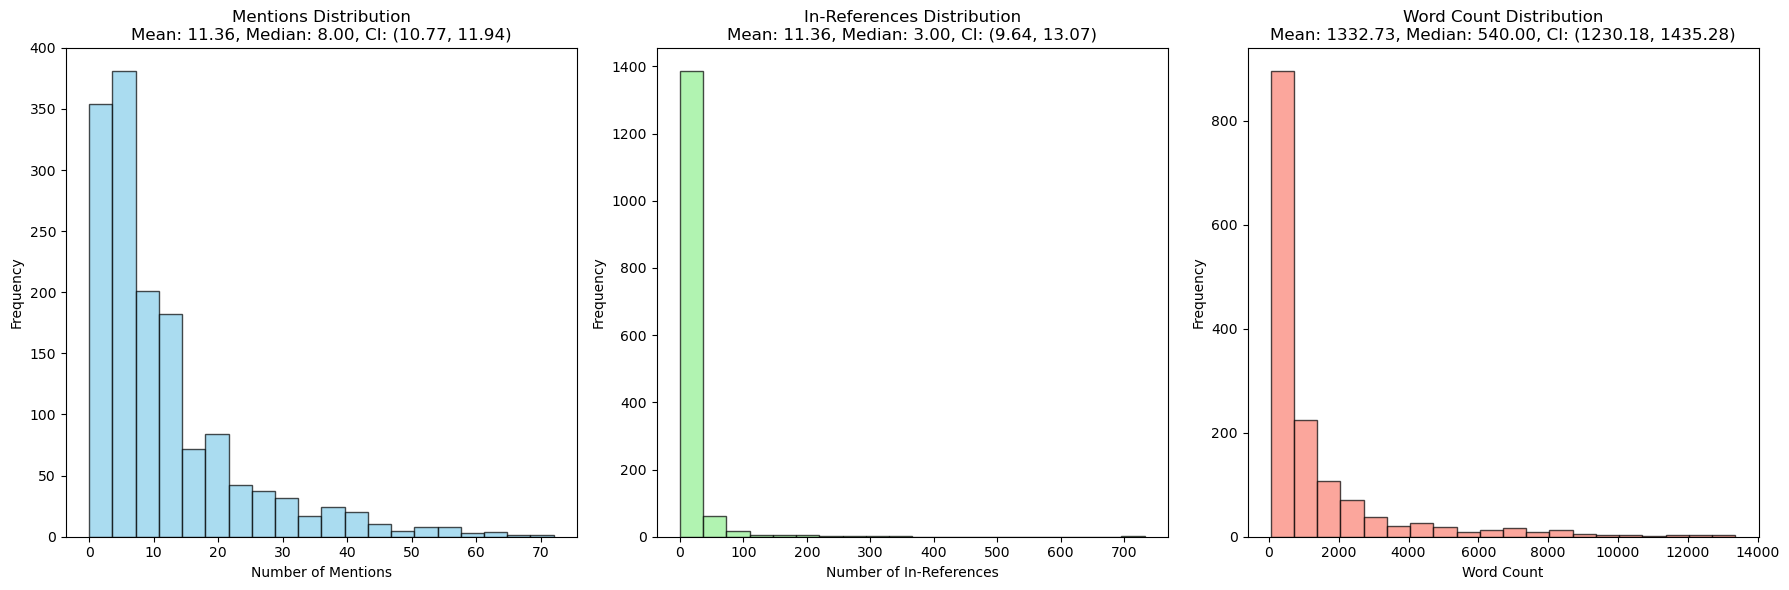

In [36]:
# Analyze and plot distributions
def analyze_and_plot(char_summary: Dict[str, Dict[str, any]]):
    # Extract data
    mention_counts = [len(data["mentions"]) for data in char_summary.values()]
    in_reference_counts = [len(data["mentioned_by"]) for data in char_summary.values()]
    word_counts = [data["word_count"] for data in char_summary.values()]
    
    # Helper to calculate statistics
    def compute_stats(data: List[int]) -> Dict[str, float]:
        mean = np.mean(data)
        median = np.median(data)
        ci = stats.norm.interval(0.95, loc=mean, scale=np.std(data) / np.sqrt(len(data)))
        return {"mean": mean, "median": median, "ci_low": ci[0], "ci_high": ci[1]}

    # Compute statistics
    mention_stats = compute_stats(mention_counts)
    in_ref_stats = compute_stats(in_reference_counts)
    word_count_stats = compute_stats(word_counts)
    
    # Print statistics
    print("Mention Stats:", mention_stats)
    print("In-Reference Stats:", in_ref_stats)
    print("Word Count Stats:", word_count_stats)
    
    # Plot distributions
    plt.figure(figsize=(18, 6))
    
    # Mentions Plot
    plt.subplot(1, 3, 1)
    plt.hist(mention_counts, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Mentions Distribution\nMean: {mention_stats["mean"]:.2f}, Median: {mention_stats["median"]:.2f}, CI: ({mention_stats["ci_low"]:.2f}, {mention_stats["ci_high"]:.2f})')
    plt.xlabel('Number of Mentions')
    plt.ylabel('Frequency')
    
    # In-Reference Plot
    plt.subplot(1, 3, 2)
    plt.hist(in_reference_counts, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.title(f'In-References Distribution\nMean: {in_ref_stats["mean"]:.2f}, Median: {in_ref_stats["median"]:.2f}, CI: ({in_ref_stats["ci_low"]:.2f}, {in_ref_stats["ci_high"]:.2f})')
    plt.xlabel('Number of In-References')
    plt.ylabel('Frequency')
    
    # Word Count Plot
    plt.subplot(1, 3, 3)
    plt.hist(word_counts, bins=20, color='salmon', edgecolor='black', alpha=0.7)
    plt.title(f'Word Count Distribution\nMean: {word_count_stats["mean"]:.2f}, Median: {word_count_stats["median"]:.2f}, CI: ({word_count_stats["ci_low"]:.2f}, {word_count_stats["ci_high"]:.2f})')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

analyze_and_plot(char_summary)

In [37]:
# import json
# # Read the character summary from the JSON file
# with open("character_summary.json", "r") as f:
#     summary = json.load(f)

### Character sorted by the three criterias

In [ ]:
def sort_summary_by_metric(char_summary, metric):
    """
    Sorts the character summary dictionary by the specified metric.

    Args:
        char_summary (dict): Dictionary containing character data.
        metric (str): The metric to sort by ('mentioned_by', 'word_count', 'mentions').

    Returns:
        dict: Sorted dictionary based on the specified metric.
        list: Sorted list of tuples (character, metric value) for debugging or inspection.
    """
    # Sort the dictionary by the specified metric
    sorted_summary = dict(sorted(char_summary.items(), key=lambda x: len(x[1][metric]) if metric in ['mentioned_by', 'mentions'] else x[1][metric], reverse=True))
    
    # Extract values for debugging/inspection
    metric_values = [(char, len(data[metric]) if metric in ['mentioned_by', 'mentions'] else data[metric]) for char, data in sorted_summary.items()]
    
    return sorted_summary, metric_values

In [54]:
# Sorted by mentions
sorted_by_out, out_values = sort_summary_by_metric(char_summary, 'mentions')
# Sorted by number of words
sorted_by_words, word_values = sort_summary_by_metric(char_summary, 'word_count')
# Sorted by mentioned_by
sorted_by_in, in_values = sort_summary_by_metric(char_summary, 'mentioned_by')

print("\nSorted by Out-Mentions:")
for char, value in out_values[:5]:
    print(f"{char}: {value}")

print("\nSorted by Word Count:")
for char, value in word_values[:5]:
    print(f"{char}: {value}")

print("\nSorted by In-Mentions:")
for char, value in in_values[:5]:
    print(f"{char}: {value}")


Sorted by Out-Mentions:
Pandaman: 72
Marco: 65
George Black: 63
Roche Tomson: 63
Carrot: 62

Sorted by Word Count:
Kaidou: 13361
Monkey D. Garp: 13206
Sabo: 12700
Kouzuki Momonosuke: 12569
Vegapunk: 12435

Sorted by In-Mentions:
Monkey D. Luffy: 732
Sanji: 360
Roronoa Zoro: 318
Nami: 300
Usopp: 274


## Filter out non relevant characters

### Creation of score metric to asses character importance

In [70]:
def calculate_scores(in_mentions, word_count, out_mentions, weights):
    """
    Calculate scores based on positions in three sorted lists.
    
    Args:
        in_mentions (list): Characters sorted by in-mentions (higher to lower).
        word_count (list): Characters sorted by word count (higher to lower).
        out_mentions (list): Characters sorted by out-mentions (higher to lower).
        weights (tuple): Weights for the three lists in the order (in_mentions, word_count, out_mentions).
    
    Returns:
        list: Sorted list of tuples (character, score) in descending order of scores.
    """
    def rank_list(sorted_list):
        # Create a rank mapping (reverse rank: higher position gets higher rank)
        return {character: len(sorted_list) - i for i, character in enumerate(sorted_list)}
    
    # Create rankings for each list
    in_mentions_ranks = rank_list(in_mentions)
    word_count_ranks = rank_list(word_count)
    out_mentions_ranks = rank_list(out_mentions)
    
    # Combine all unique characters from the lists
    all_characters = set(in_mentions_ranks) | set(word_count_ranks) | set(out_mentions_ranks)
    
    # Calculate scores for each character
    scores = {}
    for character in all_characters:
        scores[character] = (round(
            weights[0] * in_mentions_ranks.get(character, 0) +
            weights[1] * word_count_ranks.get(character, 0) +
            weights[2] * out_mentions_ranks.get(character, 0)
        , 2)
        )
    
    # Sort by score in descending order and return as a dictionary
    sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda x: x[1], reverse=True)}
    return sorted_scores

# Weights for the lists
weights = (1, 0.2, 0.1)  #  In-Mentions is 5x more important than Number of Words, and 10x more important than Out-Mentions

# Calculate scores
result = calculate_scores(sorted_by_in, sorted_by_words, sorted_by_out, weights)

# Display 10 characters with the highest scores
for char in list(result.keys())[:20]:
    print(f"{char}: {result[char]}")

Kaidou: 1925.3
Portgas D. Ace: 1917.6
Vegapunk: 1910.2
Shanks: 1907.2
Edward Newgate: 1905.1
Marshall D. Teach: 1904.9
Monkey D. Garp: 1902.8
Kouzuki Oden: 1901.1
Bartholomew Kuma: 1900.4
Sengoku: 1900.3
Gol D. Roger: 1899.9
Crocodile: 1899.8
Kouzuki Momonosuke: 1899.7
Monkey D. Luffy: 1899.0
Sakazuki: 1898.7
Sabo: 1896.8
Kin'emon: 1896.6
Borsalino: 1895.6
Eustass Kid: 1894.5
Nefertari Vivi: 1893.1


### Distribution of score metric

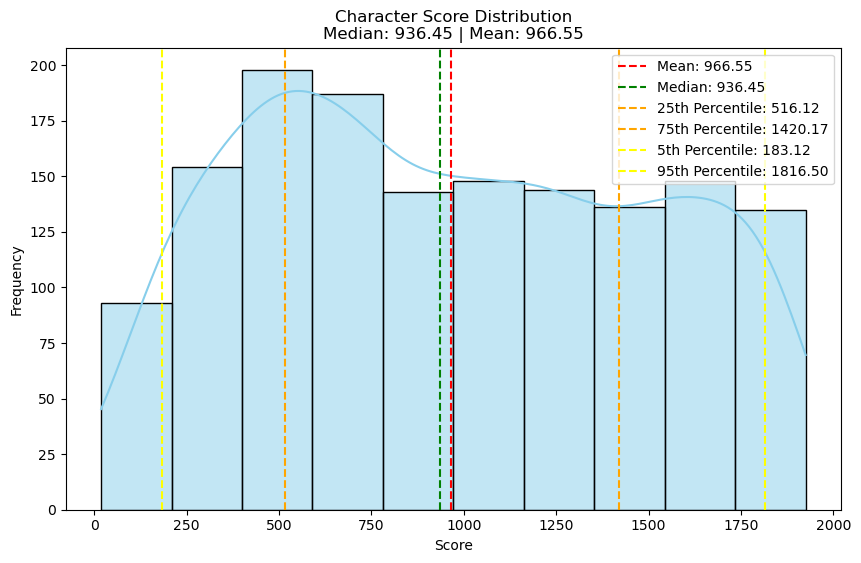

In [71]:
# Extract the scores and their corresponding character names
names = list(result.keys())
scores = list(result.values())

# Calculate statistics: mean, median, and percentiles (25th and 75th)
mean_score = np.mean(scores)
median_score = np.median(scores)
percentile_25 = np.percentile(scores, 25)
percentile_75 = np.percentile(scores, 75)
percentile_5 = np.percentile(scores, 5)
percentile_95 = np.percentile(scores, 95)

# Create the histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=10, color="skyblue", edgecolor="black")

# Add vertical lines for mean, median, percentiles, and confidence interval
plt.axvline(mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.2f}')
plt.axvline(median_score, color='green', linestyle='--', label=f'Median: {median_score:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='--', label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='orange', linestyle='--', label=f'75th Percentile: {percentile_75:.2f}')
plt.axvline(percentile_5, color='yellow', linestyle='--', label=f'5th Percentile: {percentile_5:.2f}')
plt.axvline(percentile_95, color='yellow', linestyle='--', label=f'95th Percentile: {percentile_95:.2f}')

# Add title with statistics
plt.title(f"Character Score Distribution\nMedian: {median_score:.2f} | Mean: {mean_score:.2f}")

# Add labels and legend
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

### Score Treshold Analysis for removing non important characters

Threshold: 250 - Highest score deleted: Hippie with score 249.8
Information about Hippie: {'mentions': ['Vegapunk'], 'word_count': 139, 'mentioned_by': []}

Threshold: 300 - Highest score deleted: Esta with score 299.4
Information about Esta: {'mentions': [], 'word_count': 170, 'mentioned_by': []}

Threshold: 350 - Highest score deleted: Konbu with score 348.8
Information about Konbu: {'mentions': ['Caesar Clown', 'Franky', 'Mocha', 'Nami', 'Sanji', 'Tony Tony Chopper', 'Trafalgar D. Water Law', 'Vegapunk'], 'word_count': 350, 'mentioned_by': []}

Threshold: 400 - Highest score deleted: Magra with score 398.9
Information about Magra: {'mentions': ['Bluejam', 'Curly Dadan', 'Franky', 'Monkey D. Garp', 'Monkey D. Luffy', 'Portgas D. Ace'], 'word_count': 702, 'mentioned_by': []}

Threshold: 450 - Highest score deleted: Nekozaemon with score 448.5
Information about Nekozaemon: {'mentions': ['Kaidou', 'Kazenbo', "Kin'emon", 'Kouzuki Oden', 'Kurozumi Higurashi', 'Kurozumi Kanjuro', 'Kurozumi

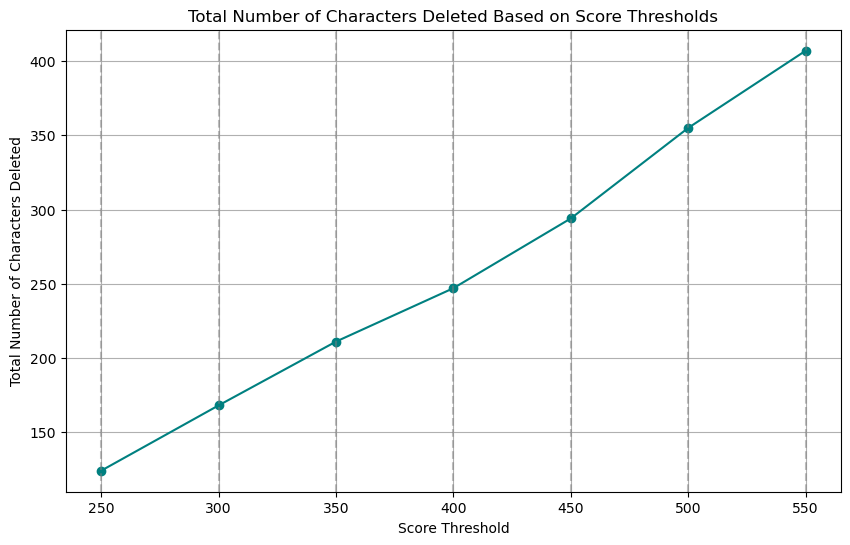

In [82]:
# Define the score thresholds you want to explore (e.g., 100, 150, ..., 450)
score_thresholds = [250, 300, 350, 400, 450, 500, 550]

# Initialize a list to store the number of characters removed and the highest score character info
num_deleted = []
deleted_character_info = []

# Loop over the score thresholds and calculate the number of characters removed
for threshold in score_thresholds:
    # Filter out characters whose scores are less than or equal to the threshold
    filtered_scores = [score for score in scores if score <= threshold]
    filtered_names = [names[i] for i in range(len(scores)) if scores[i] <= threshold]
    
    # Track the highest score character deleted
    if filtered_scores:
        max_deleted_score = max(filtered_scores)
        max_deleted_name = filtered_names[filtered_scores.index(max_deleted_score)]
        deleted_character_info.append((max_deleted_name, max_deleted_score))
    else:
        deleted_character_info.append(("None", 0))  # No character deleted if list is empty
    
    num_deleted.append(len(filtered_scores))  # Store the total number deleted

# Print out the highest score character deleted for each threshold
for i, threshold in enumerate(score_thresholds):
    character, score = deleted_character_info[i]
    print(f"Threshold: {threshold} - Highest score deleted: {character} with score {score}")
    print(f"Information about {character}: {char_summary[character]}\n")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(score_thresholds, num_deleted, marker='o', linestyle='-', color='teal')

# Add title and labels
plt.title("Total Number of Characters Deleted Based on Score Thresholds")
plt.xlabel("Score Threshold")
plt.ylabel("Total Number of Characters Deleted")

# Add vertical lines for key thresholds
for threshold in score_thresholds:
    plt.axvline(threshold, color='gray', linestyle='--', alpha=0.5)

# Show the plot
plt.grid(True)
plt.show()

I consider amazon as a quite relevant one so lets keep her as the reference value and delete the previous ones

### List of important and non important characters

In [83]:
# Based on the analysis, we can set a threshold of 550 and remove characters with scores below this threshold
threshold = 550

# Get the names of the characters with score > treshold
top_characters = [name for name, score in result.items() if score > threshold]

# Get the deleted characters
deleted_characters = [name for name, score in result.items() if score <= threshold]

# Print the before and after length of the character summary
print(f"Before: {len(char_summary)} characters")

# After removing the top characters
print(f"After: {len(top_characters)} characters")

# Print percentage of characters removed
percentage_removed = (1 - len(top_characters) / len(char_summary)) * 100
print(f"Percentage Removed: {percentage_removed:.2f}%")

Before: 1486 characters
After: 1079 characters
Percentage Removed: 27.39%


## Final summary of the selected characters

In [ ]:
# Function to remove deleted characters and update the dictionary
def remove_deleted_characters_from_summary(summary_dict, deleted_characters):
    filtered_summary = {}

    for character, data in summary_dict.items():
        # Skip the character if it's deleted
        if character in deleted_characters:
            continue

        # Filter out mentions and mentioned_by lists
        mentions = [name for name in data['mentions'] if name not in deleted_characters]
        mentioned_by = [name for name in data['mentioned_by'] if name not in deleted_characters]

        # Update the dictionary with filtered mentions and mentioned_by
        filtered_summary[character] = {
            'mentions': mentions,
            'word_count': data['word_count'],
            'mentioned_by': mentioned_by,
        }

    return dict(sorted(filtered_summary.items()))

# Apply the function to remove deleted characters
filtered_summary = remove_deleted_characters_from_summary(char_summary, deleted_characters)

# Print the filtered summary
print(f"Length filtered Summary Dictionary: {len(filtered_summary)}")

Length filtered Summary Dictionary: 1079


### Distribution of the three criteria on the filtered characters

Mention Stats: {'mean': 13.765523632993512, 'median': 10.0, 'ci_low': 13.049501331526926, 'ci_high': 14.481545934460097}
In-Reference Stats: {'mean': 13.765523632993512, 'median': 5.0, 'ci_low': 11.77574932092537, 'ci_high': 15.755297945061654}
Word Count Stats: {'mean': 1678.0982391102873, 'median': 752.0, 'ci_low': 1544.9288529488647, 'ci_high': 1811.26762527171}


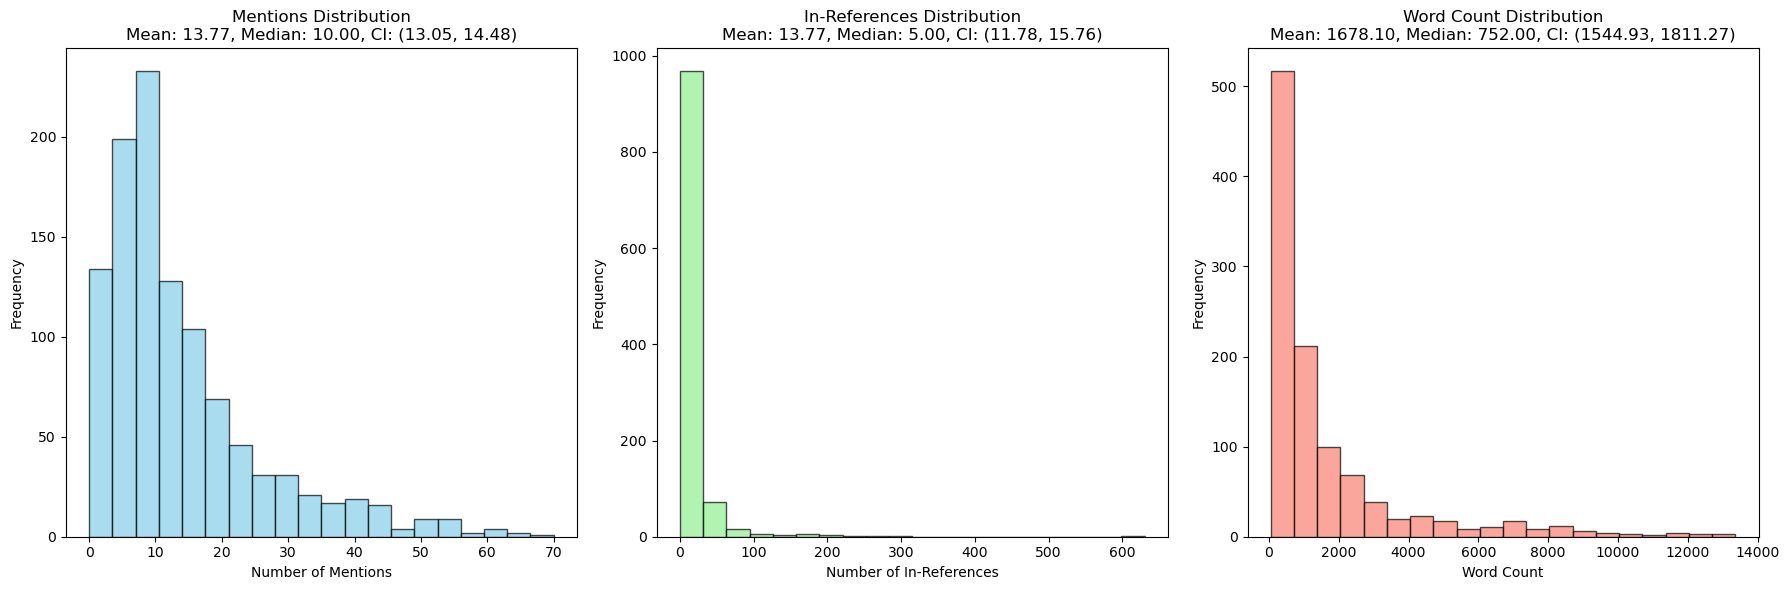

In [85]:
analyze_and_plot(filtered_summary)

In [ ]:
# Save summary as json
with open("filtered_summary.json", "w") as f:
    json.dump(filtered_summary, f, indent=4)